In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Data and Exploratory Data Analysis (EDA)
    - inspect the dataset to understand features and targets

In [6]:
df = pd.read_csv("data/Loan_Default_kaggle.csv")
df.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

## 1.1 Understand the data

In [12]:
# shape & types
print(df.shape)
print(df.info())
print(df.dtypes)

(148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges 

In [10]:
# preview the first few rows.
print("First 5 rows:")
print(df.head())

First 5 rows:
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP           758   

In [11]:
print("Last 5 rows:")
print(df.tail())

Last 5 rows:
            ID  year loan_limit             Gender approv_in_adv loan_type  \
148665  173555  2019         cf  Sex Not Available         nopre     type1   
148666  173556  2019         cf               Male         nopre     type1   
148667  173557  2019         cf               Male         nopre     type1   
148668  173558  2019         cf             Female         nopre     type1   
148669  173559  2019         cf             Female         nopre     type1   

       loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
148665           p3                l1        nopc                  nob/c  ...   
148666           p1                l1        nopc                  nob/c  ...   
148667           p4                l1        nopc                  nob/c  ...   
148668           p4                l1        nopc                  nob/c  ...   
148669           p3                l1        nopc                  nob/c  ...   

        credit_type  Credit_Sco

## 1.2 Drop duplicates and remove columns that have one unique value

In [ ]:
# Drop LoanID since it is just an identifier.
df = df.drop(columns=['LoanID'])

# Drop duplicates on features + targes
df = df.drop_duplicates()
print(df.shape)

constant_cols = df.columns[df.nunique(dropna=False) == 1]
print("Dropped constant columns:", list(constant_cols))
df = df.drop(columns=constant_cols)

(148670, 34)
Dropped constant columns: ['year']


## 1.3 Investiage conflicting rows (same features, different target)
conflict rows may indicate:
- Data entry error.
- Missing distinguishing features.
- Feature contains target info.

In [18]:
# Find rows with identical features but different targets
conflicts = df.groupby(list(df.columns.difference(['Status']))).agg({'Status': pd.Series.nunique})
conflicts = conflicts[conflicts['Status'] > 1]
print(conflicts)

Empty DataFrame
Columns: [Status]
Index: []


## 1.4 Visualize Distribution

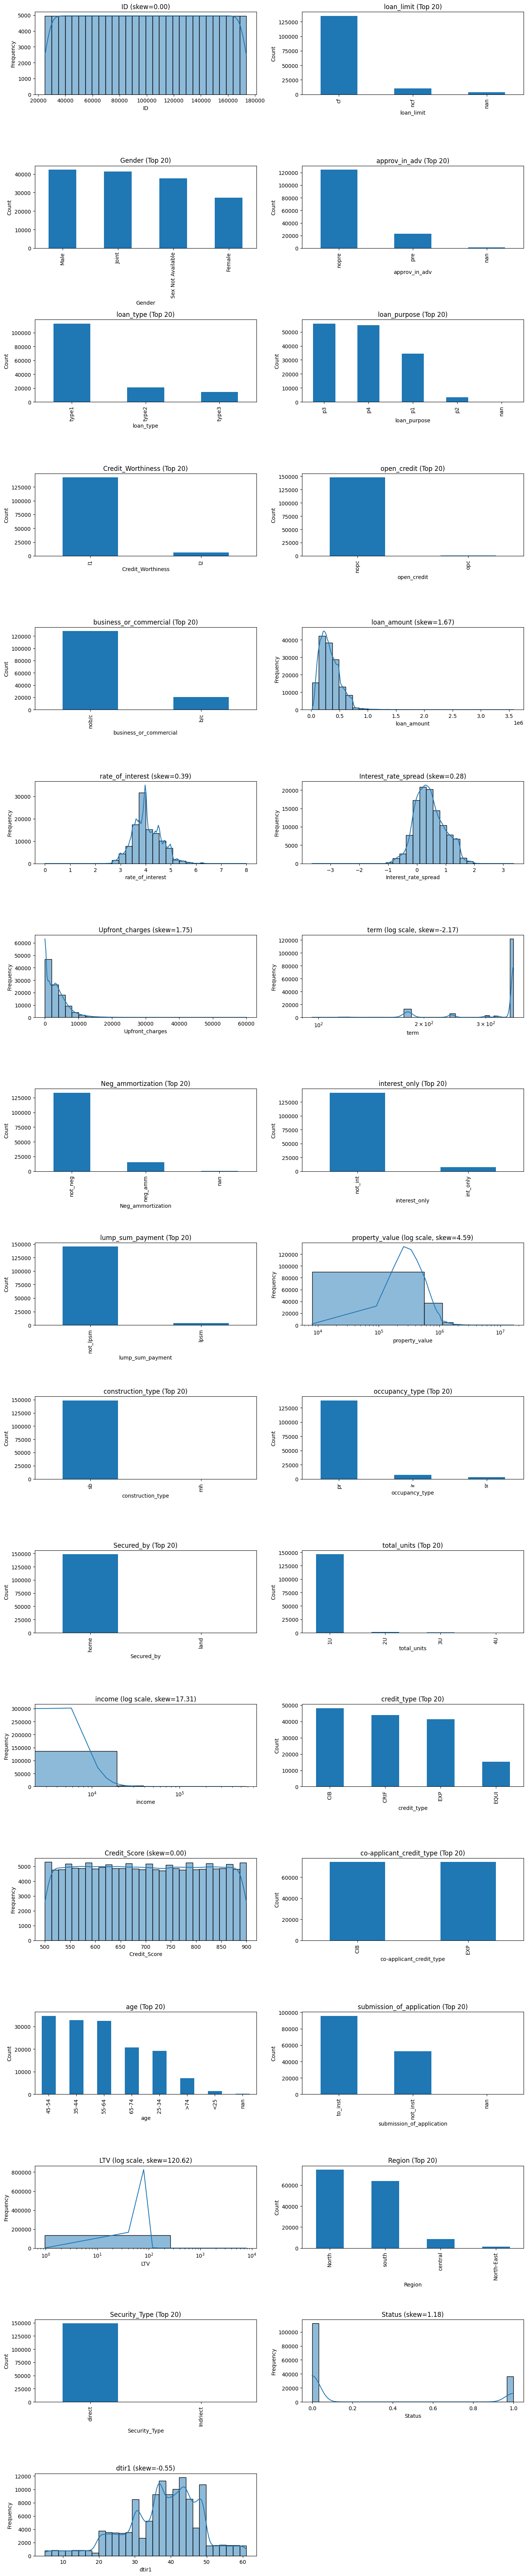

In [24]:
def plot_all_features_grid(df, top_n_categories=20, log_threshold_skew=2):
    num_cols = df.shape[1]
    n_cols = 2
    n_rows = int(np.ceil(num_cols / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(df.columns):
        ax = axes[idx]
        if pd.api.types.is_numeric_dtype(df[col]):
            skewness = df[col].skew(skipna=True)
            log_scale = abs(skewness) > log_threshold_skew
            sns.histplot(df[col].dropna(), kde=True, bins=30, ax=ax)
            if log_scale:
                ax.set_xscale('log')
                ax.set_title(f'{col} (log scale, skew={skewness:.2f})')
            else:
                ax.set_title(f'{col} (skew={skewness:.2f})')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
        else:
            vc = df[col].value_counts(dropna=False).head(top_n_categories)
            vc.plot(kind='bar', ax=ax)
            ax.set_title(f'{col} (Top {top_n_categories})')
            ax.set_xlabel(col)
            ax.set_ylabel('Count')

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_all_features_grid(df)  # Set to True to save plots

In [ ]:
# One do

## 1.5 Missing Values

In [ ]:
# Calculate the proportion of missing values
missing_ratio = df.isnull().mean().sort_values(ascending=False)

# Display only columns with missing values
missing_ratio = missing_ratio[missing_ratio > 0]
print(missing_ratio)

# Plot missing value ratio
plt.figure(figsize=(10, 6))
missing_ratio.plot(kind='barh')
plt.title("Missing Value Ratio by Feature")
plt.xlabel("Fraction Missing")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 1.6 Feature Importance

In [ ]:
def calculate_feature_importance(df, features, target):
    # Copy the original dataframe
    df_temp = df.copy()

    # Encode categorical columns and impute missing values

    for col in features:
        if df_temp[col].dtype == 'object' or df_temp[col].dtype.name == 'category':
            df_temp[col] = df_temp[col].fillna(df_temp[col].mode()[0])  # Fill with most frequent
            le = LabelEncoder()
            df_temp[col] = le.fit_transform(df_temp[col])
        else:
            df_temp[col] = df_temp[col].fillna(df_temp[col].median())  # Fill with median

    # Prepare data
    X = df_temp[features]
    y = df_temp[target]

    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Extract feature importances
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    # Print or display
    print(feature_importances)

    # Optional: plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importances, y='feature', x='importance')
    plt.title('Random Forest Feature Importances')
    plt.tight_layout()
    plt.show()

    return feature_importances

# Identify features and target
target = 'Static'
features = df.columns.drop(target)
feature_importances = calculate_feature_importance(df, features, target)

In [ ]:
# Get features with low importance
threshold = 0.005
low_importance = feature_importances[feature_importances['importance'] < threshold]
print("Features below importance threshold:")
print(low_importance)

# 2. Preprocess the Data.
- Handle missing values.
- Deal with Outliers.
- Encode categorical variables if needed.
- split data into training, validation, and test sets

# 3. Train a Model
Since it is a binary classification problem, use models like
- Logistic Regression.
- Random Forest.
- XGBoost.

# 4. Evaluate the Model.
Metrics include 
- Accuracy.
- Precision, Recall, F1-score.
- PR-AUC/ROC-AUC.
